In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
)
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt

In [3]:
df_final = pd.read_csv("../data/df_final.csv")
df_final['v2x_polyarchy_diff'] = abs(df_final['v2x_polyarchy_o'] - df_final['v2x_polyarchy_d'])
df_final['v2x_libdem_diff'] = abs(df_final['v2x_libdem_o'] - df_final['v2x_libdem_d'])
df_final['v2x_partipdem_diff'] = abs(df_final['v2x_partipdem_o'] - df_final['v2x_partipdem_d'])
df_final['v2x_delibdem_diff'] = abs(df_final['v2x_delibdem_o'] - df_final['v2x_delibdem_d'])
df_final['v2x_egaldem_diff'] = abs(df_final['v2x_egaldem_o'] - df_final['v2x_egaldem_d'])
df_final.drop(columns=[
    'v2x_polyarchy_o', 'v2x_polyarchy_d',
    'v2x_libdem_o', 'v2x_libdem_d',
    'v2x_partipdem_o', 'v2x_partipdem_d',
    'v2x_delibdem_o', 'v2x_delibdem_d',
    'v2x_egaldem_o', 'v2x_egaldem_d'
], inplace=True)

df_final.dropna(subset=['logallexports'], inplace=True)

In [4]:
df_final.columns

Index(['year', 'country_id_o', 'country_o', 'country_id_d', 'country_d',
       'contig', 'distcap', 'dist', 'comlang_off', 'comlang_ethno', 'comrelig',
       'pop_o', 'pop_d', 'gdp_o', 'gdp_d', 'gdpcap_o', 'gdpcap_d', 'fta_wto',
       'tradeflow_comtrade_o', 'tradeflow_comtrade_d', 'tradeflow_imf_o',
       'tradeflow_imf_d', 'IdealPointDistance', 'arms', 'tot_o', 'tot_d',
       'tgdp_ratio_o', 'tgdp_ratio_d', 'avgtradeflow', 'logtradeflow',
       'allexports', 'chemicalexports', 'consumerexports', 'foodexports',
       'machineryexports', 'manufacturesexports', 'logallexports',
       'logchemicalexports', 'logconsumerexports', 'logfoodexports',
       'logmachineryexports', 'logmanufacturesexports', 'v2x_polyarchy_diff',
       'v2x_libdem_diff', 'v2x_partipdem_diff', 'v2x_delibdem_diff',
       'v2x_egaldem_diff'],
      dtype='object')

In [5]:
# Define two groups of geopolitical distance based on domain knowledge & assumptions
group_positive = ['comlang_off', 'comlang_ethno', 'comrelig', 'fta_wto', 'arms']
group_negative = ['IdealPointDistance', 'v2x_polyarchy_diff', 'v2x_libdem_diff', 'v2x_partipdem_diff', 'v2x_delibdem_diff', 'v2x_egaldem_diff']

# Standardizing
scaler_pos = StandardScaler()
df_final[group_positive] = scaler_pos.fit_transform(df_final[group_positive])

scaler_neg = StandardScaler()
df_final[group_negative] = -df_final[group_negative]
df_final[group_negative] = scaler_neg.fit_transform(df_final[group_negative])

In [6]:
# Factor analysis to extract new composite measure of geopolitical distance
group_all = group_positive + group_negative
fa_all = FactorAnalysis(n_components=1, random_state=222)
factor_scores_all = fa_all.fit_transform(df_final[group_all])

df_final['geopolitical_closeness_index'] = factor_scores_all[:, 0]

In [7]:
# Re-standardize geopolitical distance
scaler_comp = StandardScaler()
df_final['geopolitical_closeness_index'] = scaler_comp.fit_transform(df_final[['geopolitical_closeness_index']])

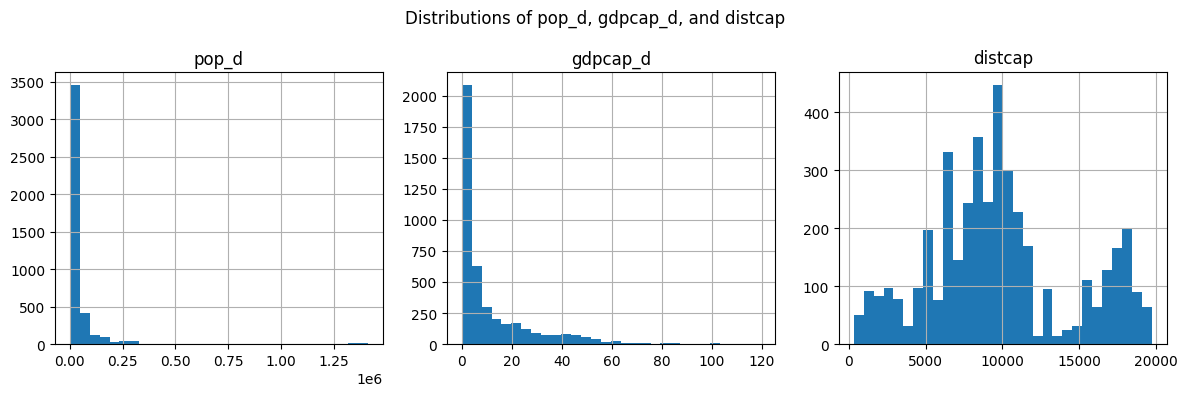

In [8]:
cols = ['pop_d', 'gdpcap_d', 'distcap']

df_final[cols].hist(bins=30, figsize=(12, 4), layout=(1, 3))
plt.suptitle("Distributions of pop_d, gdpcap_d, and distcap")
plt.tight_layout()
plt.show()

In [9]:
# Standardizing non-geopolitical measures

df_final['log_pop_d'] = np.log1p(df_final['pop_d'])
df_final['log_gdpcap_d'] = np.log1p(df_final['gdpcap_d'])
scaler = StandardScaler()
df_final[['log_pop_d', 'log_gdpcap_d', 'distcap']] = scaler.fit_transform(df_final[['log_pop_d', 'log_gdpcap_d', 'distcap']])

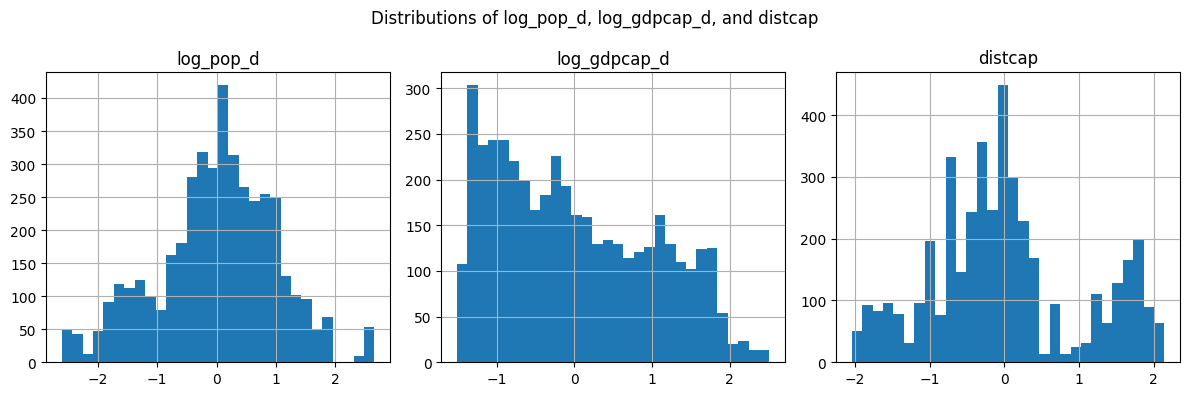

In [10]:
cols = ['log_pop_d', 'log_gdpcap_d', 'distcap']

df_final[cols].hist(bins=30, figsize=(12, 4), layout=(1, 3))
plt.suptitle("Distributions of log_pop_d, log_gdpcap_d, and distcap")
plt.tight_layout()
plt.show()

In [21]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

df_final_2 = df_final.sort_values(by='year')  # Replace 'time_variable' with your actual time column

# Modeling
target = 'logallexports'
predictors = ['log_pop_d', 'log_gdpcap_d', 'distcap', 'geopolitical_closeness_index']
X = df_final_2[predictors]
y = df_final_2[target]


# Define TimeSeriesSplit (let's use 5 splits for example)
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the model
model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=222
)

# Store results for each split
cv_results = {'rmse': [], 'r2': []}

# Perform time series cross-validation
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    cv_results['rmse'].append(rmse)
    cv_results['r2'].append(r2)

# Calculate average performance across all splits
print(f"Average RMSE: {np.mean(cv_results['rmse']):.4f}")
print(f"Average R²: {np.mean(cv_results['r2']):.4f}")


Average RMSE: 1.4258
Average R²: 0.7537


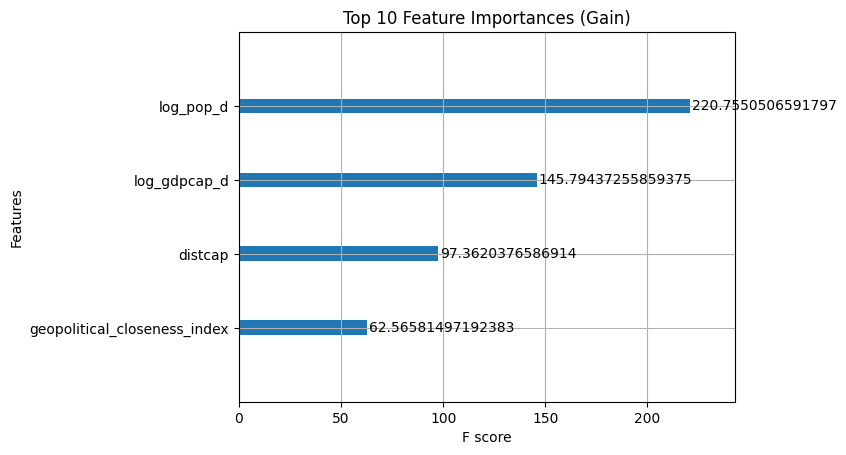

In [22]:
xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances (Gain)")
plt.show()

In [23]:
import shap
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

index_pos = list(X_test.columns).index('geopolitical_closeness_index')
feat_pos = X_test['geopolitical_closeness_index']
shap_pos = shap_values[:, index_pos]

corr_pos, p_val_pos = pearsonr(feat_pos, shap_pos)
print(f"Correlation for 'geopolitical_closeness_index': {corr_pos:.4f} (p={p_val_pos:.4f})")

Correlation for 'geopolitical_closeness_index': 0.8549 (p=0.0000)


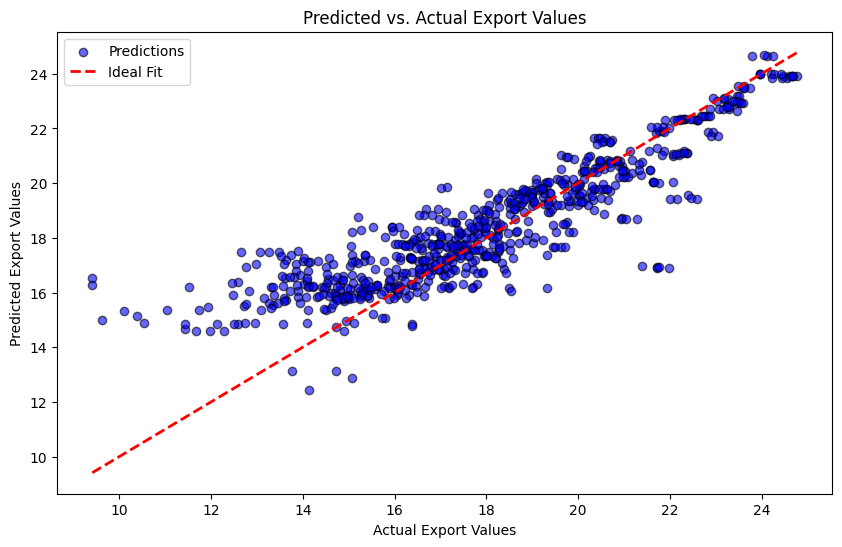

In [24]:
# Predict on the test set using your fitted model (XGBRegressor)
y_pred = model.predict(X_test)

# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolor='k', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel("Actual Export Values")
plt.ylabel("Predicted Export Values")
plt.title("Predicted vs. Actual Export Values")
plt.legend()
plt.show()

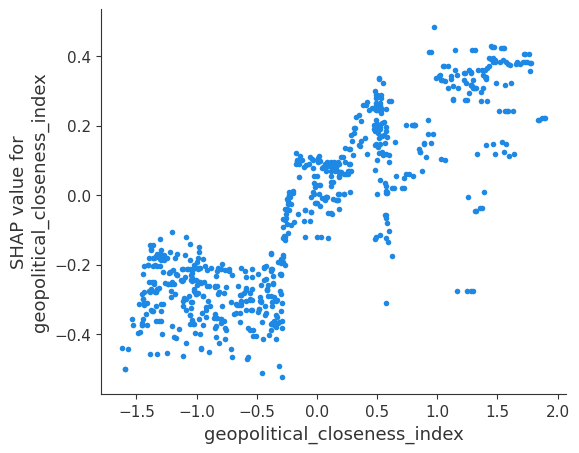

In [25]:
shap.dependence_plot('geopolitical_closeness_index', shap_values, X_test, interaction_index=None)

In [26]:
from scipy.stats import spearmanr

#check correlation between geopolitical_closeness_index and logallexports

corr_spearman, p_value_spearman = spearmanr(
    df_final['geopolitical_closeness_index'],
    df_final['logallexports']
)

print(f"Spearman Correlation: {corr_spearman:.4f} (p-value: {p_value_spearman:.4e})")

Spearman Correlation: 0.3670 (p-value: 2.4441e-136)
